https://exofop.ipac.caltech.edu/tess/target.php?id=470381900

In [1]:
import os

assert os.environ['CONDA_DEFAULT_ENV']=='exoplanet'

https://docs.exoplanet.codes/en/latest/tutorials/intro-to-pymc3/#a-more-realistic-example-radial-velocity-exoplanets

See also https://jax.exoplanet.codes/en/latest/tutorials/transit/

## Fitting upper limit of RV amplitude

In [4]:
import pandas as pd

df = pd.read_csv("../rv/rvout_TOI5671.dat",header=None,delim_whitespace=True)
df = df.drop(df.index[[5,12,16]])
print(df)

               0           1          2            3            4      5
0   2.460042e+06  236.098298  32.443436  1882.336085  1477.518555  210.0
1   2.460042e+06  276.621086  31.503643  1740.092043  1281.006233  242.0
2   2.460042e+06   -6.259502  51.382588  2156.562077  1842.144399  138.0
3   2.460042e+06   53.897957  57.897331  2222.306427  1795.776970  147.0
4   2.460042e+06  121.160048  36.540409  1893.604122  1417.525087  211.0
6   2.460074e+06 -111.844054  21.495063  1314.979623   687.026180  279.0
7   2.460075e+06  233.139018  27.708191  1530.967525   984.131208  294.0
8   2.460075e+06  197.542974  21.690891  1404.120447   819.786210  276.0
9   2.460076e+06   61.185449  35.103784  1836.272072  1302.588377  249.0
10  2.460076e+06    8.493320  25.215836  1528.987613   938.470054  287.0
11  2.460076e+06    0.000000  24.617423  1528.622869   949.482090  294.0
13  2.460157e+06 -162.903928  22.906626  1533.113860  1017.011269  291.0
14  2.460160e+06 -363.356917  24.850000  1463.17098

In [5]:
from astropy.time import Time

Time(df[0][0], format='jd').iso, Time(df[0][20], format='jd').iso

('2023-04-07 07:56:54.626', '2023-08-06 06:34:28.260')

In [6]:
# values from paper
Porb = 3.30632, 0.000004
tc = 2685.75, 0.0027523146

In [7]:
import numpy as np

t = df[0]
t -= np.mean(t)
rv = df[1]
rv_err = df[2]
t

0    -57.409607
1    -57.388329
2    -57.158571
3    -57.137288
4    -57.116017
6    -25.441870
7    -24.424805
8    -24.403531
9    -23.423137
10   -23.401863
11   -23.380587
13    57.533765
14    60.517033
15    60.538301
17    62.515130
18    62.536387
19    63.511847
20    63.533143
Name: 0, dtype: float64

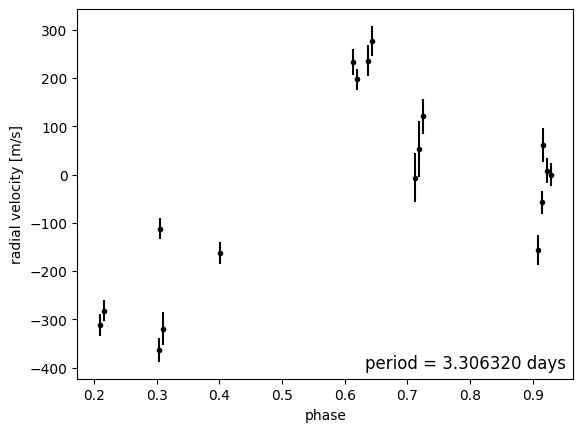

In [9]:
import matplotlib.pyplot as pl


pl.errorbar(
    (t % Porb[0]) / Porb[0], rv, yerr=rv_err, fmt=".k", capsize=0
)
# pl.xlim(0, 1)
pl.annotate(
    f"period = {Porb[0]:.6f} days",
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)
pl.ylabel("radial velocity [m/s]")
_ = pl.xlabel("phase")

In [12]:
lit_period = Porb[0]

In [18]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

import exoplanet as xo

with pm.Model() as model:
    # Parameters
    logK = pm.Uniform(
        "logK",
        lower=0,
        upper=np.log(400),
        testval=np.log(0.5 * (np.max(rv) - np.min(rv))),
    )
    logP = pm.Uniform(
        "logP", lower=0, upper=np.log(10), testval=np.log(lit_period)
    )
    phi = pm.Uniform("phi", lower=0, upper=2 * np.pi, testval=0.1)

    # Parameterize the eccentricity using:
    #  h = sqrt(e) * sin(w)
    #  k = sqrt(e) * cos(w)
    hk = pmx.UnitDisk("hk", testval=np.array([0.01, 0.01]))
    e = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    w = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))

    rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
    rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.0)

    # Deterministic transformations
    n = 2 * np.pi * tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    t0 = (phi + w) / n

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)

    # This is the line that uses the custom Kepler solver
    f = xo.orbits.get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", bkg + K * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f))
    )

    # Condition on the observations
    pm.Normal("obs", mu=rvmodel, sd=rv_err, observed=rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = xo.orbits.get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred))
    )

In [19]:
with model:
    map_params = pmx.optimize()

optimizing logp for variables: [rvtrend, rv0, hk, phi, logP, logK]


message: Optimization terminated successfully.
logp: -1442.413495196032 -> -259.4452126749618


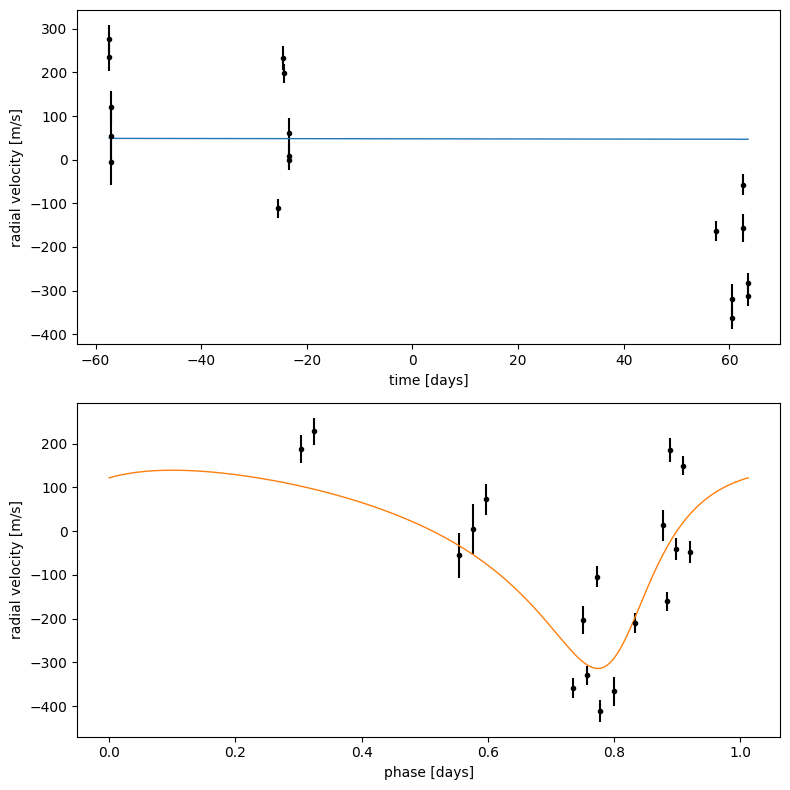

In [20]:
fig, axes = pl.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.plot(t, map_params["bkg"], color="C0", lw=1)
# ax.set_ylim(-110, 110)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.plot(phase * period, map_params["rvphase"], color="C1", lw=1)
# ax.set_ylim(-110, 110)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

pl.tight_layout()

In [21]:
with model:
    trace = pmx.sample(
        draws=1000,
        tune=1000,
        start=map_params,
        chains=2,
        cores=2,
        target_accept=0.95,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rvtrend, rv0, hk, phi, logP, logK]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [24]:
import arviz as az

az.summary(
    trace,
    var_names=["logK", "logP", "phi", "e", "w", "rv0", "rvtrend"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logK,5.424,0.048,5.337,5.514,0.001,0.001,1729.0,1249.0,1.0
logP,0.012,0.000,0.012,0.013,0.000,0.000,1292.0,1117.0,1.0
phi,1.308,0.074,1.167,1.446,0.002,0.002,1150.0,767.0,1.0
e,0.451,0.043,0.361,0.527,0.001,0.001,1739.0,1275.0,1.0
w,-2.548,0.738,-3.019,-2.285,0.030,0.021,1522.0,1047.0,1.0
rv0,47.835,7.917,33.607,62.123,0.175,0.124,2066.0,1506.0,1.0
rvtrend,-6.346,10.237,-24.607,13.707,0.216,0.206,2247.0,1365.0,1.0


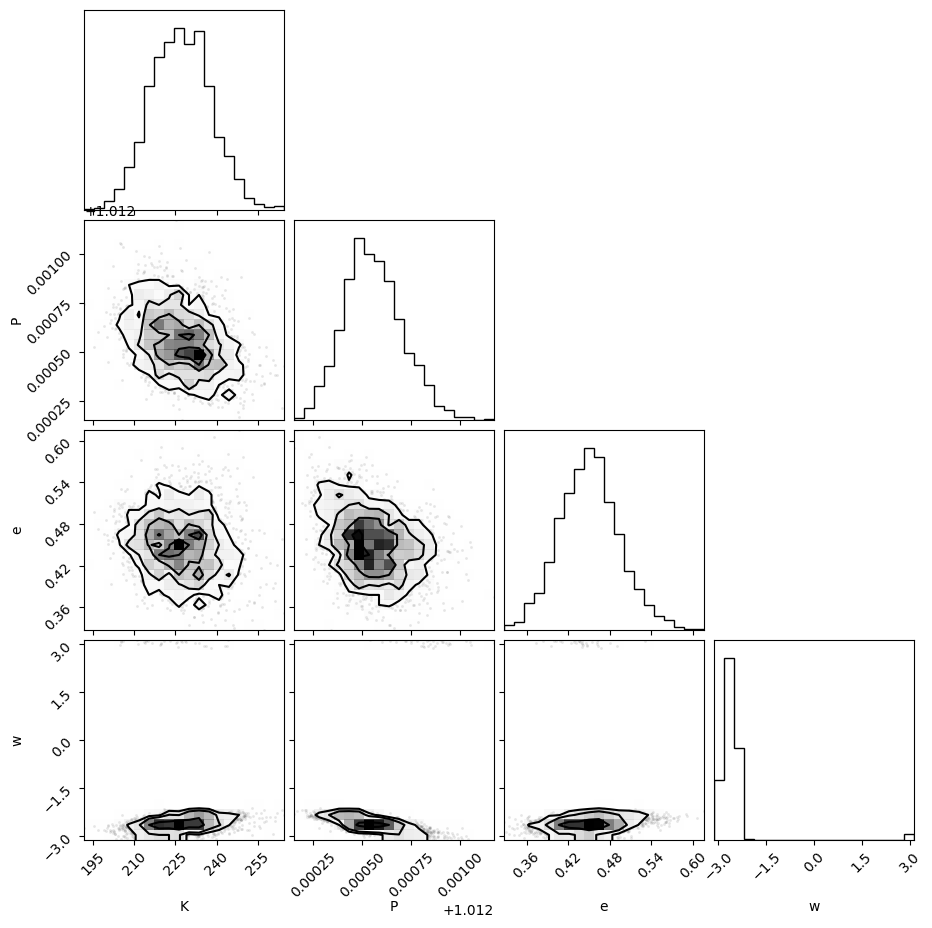

In [27]:
import corner

_ = corner.corner(trace, var_names=["K", "P", "e", "w"])

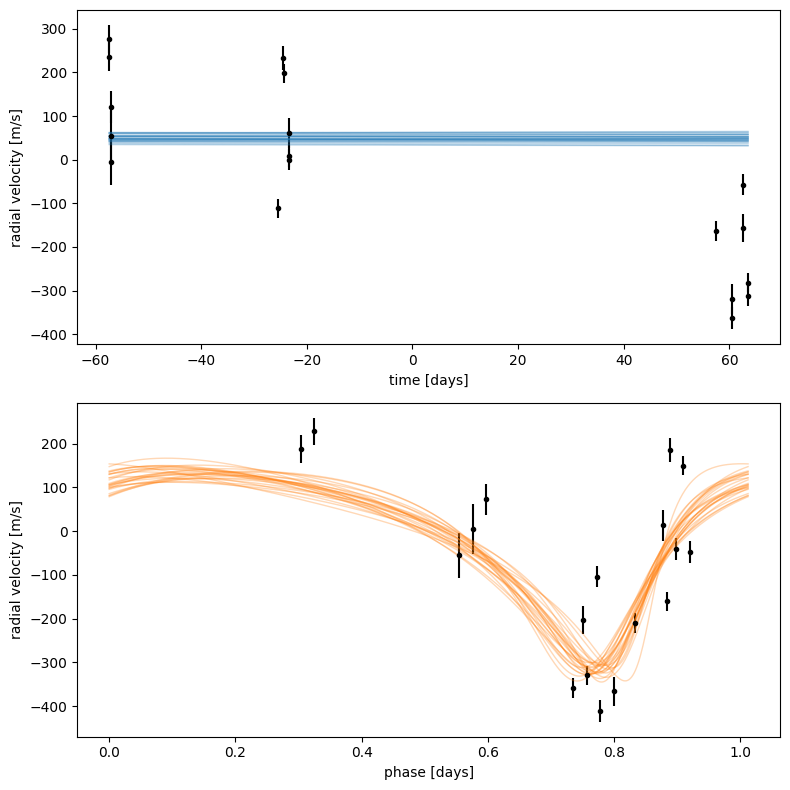

In [29]:
fig, axes = pl.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

bkg = trace.posterior["bkg"].values
rvphase = trace.posterior["rvphase"].values

for ind in np.random.randint(np.prod(bkg.shape[:2]), size=25):
    i = np.unravel_index(ind, bkg.shape[:2])
    axes[0].plot(t, bkg[i], color="C0", lw=1, alpha=0.3)
    axes[1].plot(phase * period, rvphase[i], color="C1", lw=1, alpha=0.3)

# axes[0].set_ylim(-110, 110)
# axes[1].set_ylim(-110, 110)

pl.tight_layout()